# Final Project Submission

* Student name: Sabina Bains
* Student pace: Self Paced
* Scheduled project review date / time: 3/28/2022 @ 12 pm PCT
* Instructor name: Claude Fried

## Business Understanding

A volunteer organization in New York City called *Jump Start* wants to help high school students find success in the classroom. *Jump Start*  plans to work with struggling school districts in the area to provide tutoring for high school children they believe need additional support to pass their classes, however tutors are limited, and the organization is unsure how to predict which students will need support the most.

Our suggestion is to use a supervised learning approach to predict students that are at risk to fail their courses, specifically with classification models. Portugal has obtained [data](https://www.kaggle.com/impapan/student-performance-data-set) on demographic and social characteristics of students in multiple high schools in the area, along with their final course grade. By training our model on this data, we can predict which students are likely to fail their courses based on the attributes given. Lastly, school districts can distribute surveys to collect this data at the beginning of the school year, and we can predict whether each student should be assigned a tutor based on their pass/fail classification. A pass grade is defined as a 60% (D) or higher for these districts.

As more data is gathered, our model can improve further and potentially be used at a national level to provide schools with the ability to help students in need of support. 

## Data Understanding

##### Reading in necessary packages

In [1]:
# Importing neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from matplotlib import style
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from math import e

style.use('dark_background')
pd.set_option("display.max_columns", 100)

##### Reading in datasets, understanding data

In [2]:
# reading in math and language datasets
mat  = pd.read_csv('data/student-mat.csv', sep=';')
lan = pd.read_csv('data/student-por.csv', sep=';')

# adding column to distiguish subject
mat['subject'] = 'Math'
lan['subject'] = 'Language'

#concatenating into one df
df = pd.concat([mat,lan])

#looking at first 5 rows
print('''Interesting columns to work with. We have basic information such as gender, age and location, but additionally have information on parents' education and
careers, student's basic aspirations and interests, as well as time spent doing various activities. Lastly, we have the final grade of that student.''')
df.head()

Interesting columns to work with. We have basic information such as gender, age and location, but additionally have information on parents' education and
careers, student's basic aspirations and interests, as well as time spent doing various activities. Lastly, we have the final grade of that student.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,Math
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,Math
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,Math
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,Math
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,Math


In [3]:
# checking rows and columns. required number of rows and columns are satisfied
df.shape

(1044, 34)

Text(0, 0.5, 'Count')

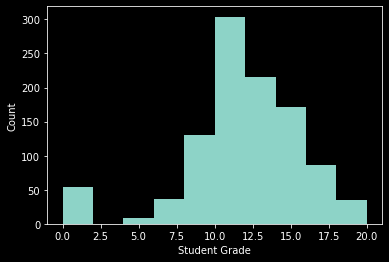

In [4]:
# looking at distribution of final grades, we will use this as our outcome variable and recode it to be binary based on whether the student passes / fails. 
plt.hist(df.G3)
plt.xlabel('Student Grade')
plt.ylabel('Count')

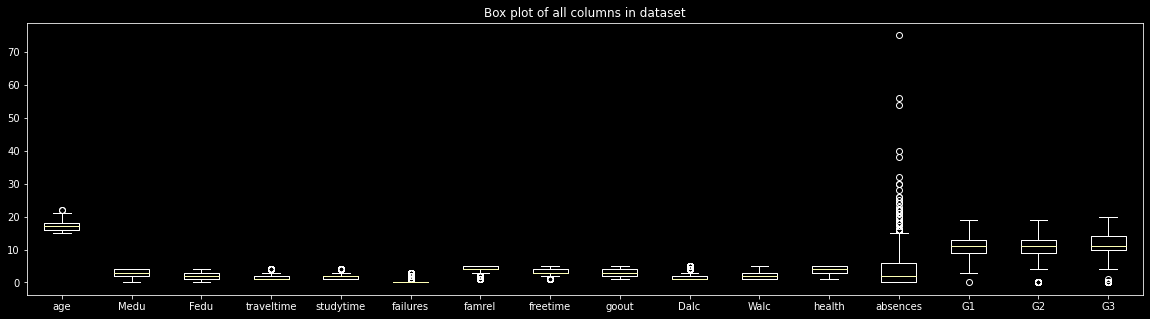

In [5]:
# Taking a look at spread for each numeric column.  looks like absences are very positively skewed
# will potentially need to scale data
plt.figure(figsize=(20, 5))
plt.boxplot([df[col] for col in df.columns if df[col].dtype != 'O'])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(1,17), [col for col in df.columns if df[col].dtype != 'O'])
plt.show()

## Preprocessing

##### Checking dtypes. will need to change some numeric data to string. No missing data

In [6]:
# Checking dtypes. Have a good mix of numeric and categorical data to work with. Will need to change some numeric to str type.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher   

In [7]:
# creating a list of columns to convert from numeric to string
cols_to_convert = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup',
                   'famsup','paid','activities','nursery','higher','romantic','internet']

In [8]:
# Looping through columns that we need to convert to string (as listed above)
for col in cols_to_convert:
    df[col] = df [col].astype('str')

In [9]:
# Creating function to change outcome variable to be binary based on pass/fail status. < 60% or >= 60%
def create_binary_outcome(x):
    if x < 12:
        return 1 #Fail
    else:
        return 0 #Pass

# applying function to outcome column
df['final_grade'] = df['G3'].apply(create_binary_outcome)

##### Looking at distribution of outcome variable

In [10]:
# looking at the distribution of the outcome variable (pass/fail). class is balanced
balance = df.final_grade.value_counts(normalize=True)
print('Class Distribution:\nPass (0): ','{:0.1%}'.format(balance[0]))
print('Fail (1): ','{:0.1%}'.format(balance[1]))

Class Distribution:
Pass (0):  48.9%
Fail (1):  51.1%


In [11]:
# Dropping columns that are not of interest. We want this dataset to be generalized to multiple schools so don't need school type
# also dropping mid period grades and absences / failures as this is too predictive & we want to predict for the beginning of the school year
cols_to_drop = ['school','G1','G2','G3','failures','subject']
df = df.drop(cols_to_drop, axis=1)

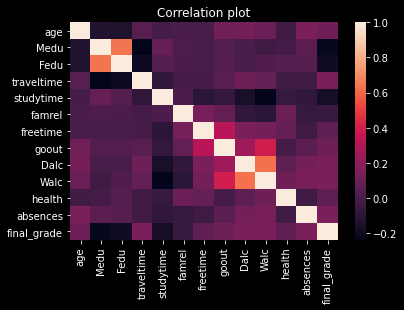

In [12]:
# viewing correlation between features (in case we use Logistic Regression)
sns.heatmap(df.corr())
plt.title("Correlation plot")
plt.show()

In [13]:
# Another correlation view. looks like features are not highly correlated
df_corr = df.corr().abs().stack().reset_index()
df_corr['preds'] = df_corr['level_0']+' & '+df_corr['level_1']
df_corr = df_corr.drop(['level_0','level_1'],axis = 1).rename(columns={0:'corr'}).sort_values(by='corr',ascending = False)
df_corr.loc[(df_corr['corr'] != 1)].head()

,corr,preds
27,0.642063,Fedu & Medu
15,0.642063,Medu & Fedu
113,0.627814,Dalc & Walc
125,0.627814,Walc & Dalc
100,0.399794,goout & Walc


##### Transforming categorical data into dummy variables

In [14]:
# Transforming categorical variables into dummies. don't need to drop first as multicollinearity is not an issue
df = pd.get_dummies(df)

In [15]:
# Splitting data into Features and Target
X = df.drop('final_grade',axis = 1)
y = df['final_grade']

##### Splitting data into test and train data

In [16]:
# Train Test Split, fitting models on Training data to assess performance on Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

## Modeling

##### Creating function to evaluate accuracy of models with less  code

In [17]:
def model_eval(model,X_train,y_train,X_test,y_test,cm=False, recall=False):
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    # Accuracy= Number of True Positives + True Negatives / Total Observations
    print('{} Results:'.format(model))
    print('Training Accuracy: ', '{:0.3%}'.format(accuracy_score(y_train, y_hat_train)))
    print('Testing Accuracy: ', '{:0.3%}\n'.format(accuracy_score(y_test, y_hat_test)))
    if recall == True:
        # Recall - Out of all the athletes who ran under target, how many did our model correctly predict?
        print('Training Recall: ', '{:0.3%}'.format(recall_score(y_train, y_hat_train)))
        print('Testing Recall: ', '{:0.3%}\n'.format(recall_score(y_test, y_hat_test)))
    
    if cm == True:
        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Greys)

#### Running First Classification Model Type  - Log Regression

LogisticRegression() Results:
Training Accuracy:  73.391%
Testing Accuracy:  65.507%


 Our first model has an training accuracy of 73%, and testing of 65%, however we are getting a convergence warning so we need to scale our data and rerun.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


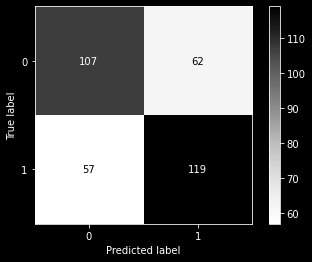

In [45]:
# Running First Model, Logistic Regression

# initializing logreg classifier and fitting on training data
logreg = LogisticRegression()
model_log = logreg.fit(X_train, y_train)

# checking evaluation
model_eval(model_log,X_train,y_train,X_test,y_test, cm=True)

print('''\n Our first model has an training accuracy of 73%, and testing of 65%, however we are getting a convergence warning so we need to scale our data and rerun.''')

##### Normalizing the Data

In [19]:
# Because we are getting a Convergence Warning, we should scale our data. 
# scaling sets all features to have a mean value of 0 and standard deviation of 1.
scaler = StandardScaler()

#Fit and transform on the training dataset only
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

#transfrorm only on the test dataset to avoid data leakage
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

##### New Model - Log Regression with Scaled Data

In [20]:
# fitting second model with scaled data
logreg_2 = LogisticRegression(solver='liblinear')
model_log_scaled = logreg.fit(X_train_scaled, y_train)

In [21]:
# Evaluating model
model_eval(model_log_scaled, X_train_scaled, y_train, X_test_scaled, y_test)

print('''This new model has similar accuracy values with more accurate data (features are no longer getting incorrectly weighted based on the range of variables).
We can potentially tune this model further, but first taking a look at other classification types, such as decision trees.''')

LogisticRegression() Results:
Training Accuracy:  73.534%
Testing Accuracy:  66.377%

This new model has similar accuracy values with more accurate data (features are no longer getting incorrectly weighted based on the range of variables).
We can potentially tune this model further, but first taking a look at other classification types, such as decision trees.


In [22]:
# Can potentially tune model further to increase accuracy, but will take a look at Decision Trees first. as DT's handle categorical data well and are easy to explain
model_log.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

##### Modeling - Decision Trees

DecisionTreeClassifier() Results:
Training Accuracy:  98.712%
Testing Accuracy:  63.478%

Training models are performing exceptionally well while the testing is only at ~58% accuracy. model is severly overfitting. We need to prune this tree


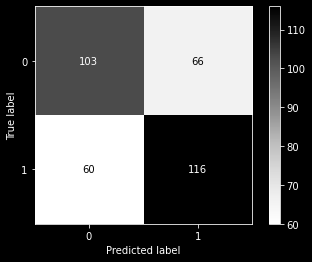

In [23]:
# Checking if a Decision Tree can outperform Logistic Regression:

# fitting decision tree classifier
dt = DecisionTreeClassifier()
model_dt = dt.fit(X_train, y_train)

# evaluating model
model_eval(model_dt, X_train, y_train, X_test, y_test, cm = True)
print('Training models are performing exceptionally well while the testing is only at ~63% accuracy. model is severly overfitting. We need to prune this tree')

##### Modeling - Decision Tree with Pruning

In [24]:
# fitting new decision tree classifier with max_depth = 6
dt2 = DecisionTreeClassifier(max_depth=6)
model_dt2 = dt2.fit(X_train, y_train)

# evaluating new model
model_eval(model_dt2, X_train, y_train, X_test, y_test)
print('''Pruning tree to change max_depth. max_depth sets the maximum depth the tree can be, as too many splits until nodes are 'pure' can cause overfitting. This
is helping increase test data and bridging gap between train and test accuracies. let's prune some more.''')

DecisionTreeClassifier(max_depth=6) Results:
Training Accuracy:  75.966%
Testing Accuracy:  61.159%

Pruning tree to change max_depth. max_depth sets the maximum depth the tree can be, as too many splits until nodes are 'pure' can cause overfitting. This
is helping increase test data and bridging gap between train and test accuracies. let's prune some more.


In [44]:
# changing samples_split to 0.1 further improves the model. 
dt3 = DecisionTreeClassifier(max_depth=6, min_samples_split=0.1)
model_dt3 = dt3.fit(X_train, y_train)

model_eval(model_dt3, X_train, y_train, X_test, y_test)
print('''Our model further improves when adjusting the minimum samples split value to 0.1. This sets the minimum samples required to split a node in the tree 
(10% of the sample) However it is still overfitting based on the difference in training and testing accuracty values, and our test data is not very high. Before we tune
some more, let's test the accuracy of random forests, as they are more robust to outliers and may generate higher scores''')

DecisionTreeClassifier(max_depth=6, min_samples_split=0.1) Results:
Training Accuracy:  70.815%
Testing Accuracy:  62.319%

Our model further improves when adjusting the minimum samples split value to 0.1. This sets the minimum samples required to split a node in the tree 
(10% of the sample) However it is still overfitting based on the difference in training and testing accuracty values, and our test data is not very high. Before we tune
some more, let's test the accuracy of random forests, as they are more robust to outliers and may generate higher scores


In [26]:
# taking a look at parameters we can adjust
dt3.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.1,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

##### Modeling - Random Forests

In [27]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier() #criterion='gini', min_samples_leaf=0.1, min_samples_split=0.1
model_rf = forest.fit(X_train,y_train)

# Evaluate
model_eval(model_rf,X_train,y_train,X_test,y_test)
           
print('''Random forests are a ensemble of multiple decision trees. data is partitioned randomly into train and testing data for each decision tree, then all trees vote
on a prediction based on the majority rule.''')

RandomForestClassifier() Results:
Training Accuracy:  98.712%
Testing Accuracy:  66.667%

Random forests are a ensemble of multiple decision trees. data is partitioned randomly into train and testing data for each decision tree, then all trees vote
on a prediction based on the majority rule.


In [28]:
# creating param grid to apply to random forest model
rf_param_grid = {
    'criterion':['gini','entropy'], # Different methods towards splitting (both have their own pro's and cons)
    'max_depth':[None,5,7,8], # Maximum depth of the tree
    'min_samples_split':[0.05,0.1,0.2,0.3], # Minimum sample required to split (percentage of total sample)
    'min_samples_leaf':[0.1,0.2,0.3] # Minumum sample each leaf node can have (percentage of total sample)
                }

In [29]:
# Instantiate GridSearchCV
rf_cv = GridSearchCV(model_rf, rf_param_grid, scoring='accuracy')

# Fit to the data
rf_cv.fit(X_train, y_train)

# evaluating data
print('Test Accuracy: ','{:0.3%}'.format(rf_cv.best_score_))

Test Accuracy:  65.520%


In [30]:
# looking at the best parameters chosen by the grid search
rf_cv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.3}

##### Modeling - Further tuning inital Logistic Regression Model

In [31]:
# When tackling overfitting, the model's accuracy falls to below our logistic regression model (model 1). lets go back to that and tune.
# Looking at parameters for logistic regression
model_log_scaled.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [32]:
log_param_grid = {
    'C':[1,1e2,1e3], #High C gives higher weight to training data (bigger chance of overfitting)
    'fit_intercept':[True,False],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }

In [33]:
# Instantiate GridSearchCV
log_cv = GridSearchCV(model_log_scaled, log_param_grid, scoring='accuracy')

# Fit to the data
log_cv.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 100.0, 1000.0],
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [34]:
# evaluating model
print('Test Accuracy: ','{:0.3%}'.format(log_cv.best_score_))

Test Accuracy:  66.098%


##### Quick look at K Nearest Neighbors to see if we can generate a higher accuracy score

In [35]:
# looking up the best K for KNN. KNN only has one major hyperparameter we can tune, and is relatively intuitive (distance based model)
def find_best_k(X_train_scaled, y_train, X_test_scaled, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0
    for i in range(min_k,max_k+1, 2):
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X_train_scaled,y_train)
        test_preds = clf.predict(X_test_scaled)
        score = accuracy_score(y_test,test_preds)
        if score > best_score:
            best_score = score
            best_k = i     
    return best_k

best_k = find_best_k(X_train_scaled, y_train, X_test_scaled, y_test)

In [36]:
# Taking a look at KNN models to compare
knn = KNeighborsClassifier(n_neighbors = best_k)

# fitting classifier
model_knn = knn.fit(X_train_scaled, y_train)

# predicting on scaled set
model_eval(model_knn,X_train_scaled,y_train,X_test_scaled,y_test)

KNeighborsClassifier() Results:
Training Accuracy:  75.823%
Testing Accuracy:  64.638%



##### Looking at accuracy scores for all models side by side

In [37]:
# Looking at all model iterations together to decide which model is best
print(' Accuracy and Recall Scores of all models tested:\n----------------------------------\n')
model_eval(model_log_scaled,X_train_scaled,y_train,X_test_scaled, y_test)
model_eval(model_dt,X_train,y_train,X_test, y_test)
model_eval(model_dt2,X_train,y_train,X_test, y_test)
model_eval(model_dt3,X_train,y_train,X_test, y_test)
model_eval(model_rf,X_train,y_train,X_test, y_test)
print(rf_cv,'\nTest Accuracy: ','{:0.3%}\n'.format(rf_cv.best_score_))
model_eval(model_knn,X_train_scaled,y_train, X_test_scaled, y_test)
print(log_cv,'\nTest Accuracy: ','{:0.3%}'.format(log_cv.best_score_))

 Accuracy and Recall Scores of all models tested:
----------------------------------

LogisticRegression() Results:
Training Accuracy:  73.534%
Testing Accuracy:  66.377%

DecisionTreeClassifier() Results:
Training Accuracy:  98.712%
Testing Accuracy:  63.478%

DecisionTreeClassifier(max_depth=6) Results:
Training Accuracy:  75.966%
Testing Accuracy:  61.159%

DecisionTreeClassifier(max_depth=6, min_samples_split=0.1) Results:
Training Accuracy:  70.815%
Testing Accuracy:  62.319%

RandomForestClassifier() Results:
Training Accuracy:  98.712%
Testing Accuracy:  66.667%

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 7, 8],
                         'min_samples_leaf': [0.1, 0.2, 0.3],
                         'min_samples_split': [0.05, 0.1, 0.2, 0.3]},
             scoring='accuracy') 
Test Accuracy:  65.520%

KNeighborsClassifier() Results:
Training Accuracy:  75.823%
Testing A

##### Creating Final Model based on evaluation done in previous step

In [38]:
# evaluating coefficients for best parameters found in our Logistic Regression grid search
final_model = LogisticRegression(C = log_cv.best_params_['C'], 
                                 fit_intercept= log_cv.best_params_['fit_intercept'], 
                                 solver=log_cv.best_params_['solver'])

final_model.fit(X_train_scaled,y_train)
model_eval(final_model, X_train_scaled, y_train, X_test_scaled, y_test)

LogisticRegression(C=1, solver='newton-cg') Results:
Training Accuracy:  73.534%
Testing Accuracy:  66.377%



## Model Evaluation

LogisticRegression(C=1, solver='newton-cg') Results:
Training Accuracy:  73.534%
Testing Accuracy:  66.377%

Training Recall:  72.346%
Testing Recall:  67.614%



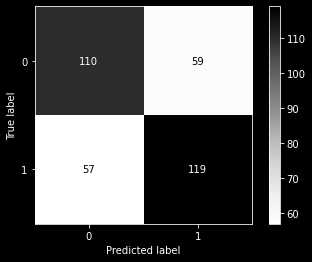

In [39]:
model_eval(final_model, X_train_scaled, y_train, X_test_scaled, y_test, cm=True, recall=True)

In [47]:
print('''
    The final model chosen is the logistic regression model with tuned parameters obtained through a grid search. this result had the highest accuracy score, although
only marginally. Most importantly, the gap between testing and training accuracies indicates the model is not overfitting. This means the model will not be sensitive
to noise, and therefore more accurate on unseen data when predicting grades for students in the upcoming school year.\n
    Although Decision Trees had a similar score to Logistic Regression, they do not derive the significance of features in their models, whereas Logistic 
Regression does. We can directly see which features increase the odds of failure among students, and to what extent. This is shown in the loop below, as we can see
increased absences and time going out increase the odds of failure. This will help us indicate which survey questions are most crucial to ask our students, to better predict
their final grade and allocate our resources to those who need them most. Lastly, although Decision trees are unafected by multicollinearity, we can see that this 
was not an issue within our dataset, and therefore is not a reason to dismiss regression.\n
    Overall, this result is not particularly strong. a testing recall of 67% means that our model will predict that 32% of all students who will fail at the end of the
school year will in fact pass, which is not the case. We will need more robust data or different predictors to better assist our stakeholder in determining which 
students to provide tutors for.''')


    The final model chosen is the logistic regression model with tuned parameters obtained through a grid search. this result had the highest accuracy score, although
only marginally. Most importantly, the gap between testing and training accuracies indicates the model is not overfitting. This means the model will not be sensitive
to noise, and therefore more accurate on unseen data when predicting grades for students in the upcoming school year.

    Although Decision Trees had a similar score to Logistic Regression, they do not derive the significance of features in their models, whereas Logistic 
Regression does. We can directly see which features increase the odds of failure among students, and to what extent. This is shown in the loop below, as we can see
increased absences and time going out increase the odds of failure. This will help us indicate which survey questions are most crucial to ask our students, to better predict
their final grade and allocate our resources to those 

In [41]:
# creating dataframe with features and coefficients side by side for evaluation
coefs = pd.concat([pd.DataFrame(X_train_scaled.columns, columns=['feature']),pd.DataFrame(model_log_scaled.coef_[0], columns = ['coefficient'])], axis=1)
coefs = coefs.sort_values(by='coefficient', ascending = False)

In [54]:
coefs.head

<bound method NDFrame.head of               feature  coefficient
11           absences     0.378345
10             health     0.258440
38      schoolsup_yes     0.248053
47          higher_no     0.195106
8                Dalc     0.174500
7               goout     0.158193
20       Mjob_at_home     0.152516
30      reason_course     0.139777
42           paid_yes     0.132545
3          traveltime     0.119757
26        Fjob_health     0.113237
14          address_R     0.112808
0                 age     0.099057
28      Fjob_services     0.085779
24       Mjob_teacher     0.068348
40         famsup_yes     0.060068
16        famsize_GT3     0.037867
43      activities_no     0.032742
36     guardian_other     0.027908
52       romantic_yes     0.026403
31        reason_home     0.023231
6            freetime     0.019971
13              sex_M     0.010056
50       internet_yes     0.010023
46        nursery_yes     0.003972
18          Pstatus_A     0.003939
34    guardian_father    

In [42]:
# Printing coefficents from final model
for feat, coef in zip(coefs.feature, coefs.coefficient):
    if coef > 0:
        print('students with '+feat+' are associated with '+'{:.1%}'.format((e**coef)-1)+' increased odds of failing')
    if coef <= 0:
        print('students with '+feat+' are associated with'+'{:.1%}'.format((e**coef)-1)+' decreased odds of failing')

students with absences are associated with 46.0% increased odds of failing
students with health are associated with 29.5% increased odds of failing
students with schoolsup_yes are associated with 28.2% increased odds of failing
students with higher_no are associated with 21.5% increased odds of failing
students with Dalc are associated with 19.1% increased odds of failing
students with goout are associated with 17.1% increased odds of failing
students with Mjob_at_home are associated with 16.5% increased odds of failing
students with reason_course are associated with 15.0% increased odds of failing
students with paid_yes are associated with 14.2% increased odds of failing
students with traveltime are associated with 12.7% increased odds of failing
students with Fjob_health are associated with 12.0% increased odds of failing
students with address_R are associated with 11.9% increased odds of failing
students with age are associated with 10.4% increased odds of failing
students with Fjob

#### Vizualization for PPT

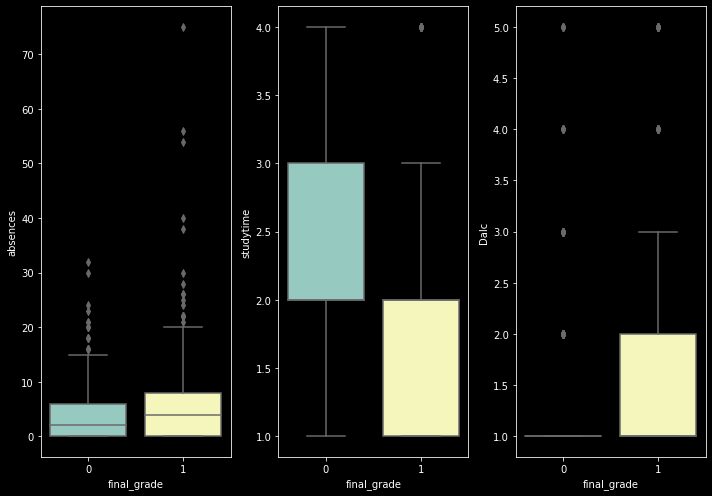

In [48]:
# Visualize relationship between promoted and other features
fig= plt.figure(figsize=(10,7) )
fig.add_subplot(1,3,1)
ar_6=sns.boxplot(x=df["final_grade"],y=df["absences"])
fig.add_subplot(1,3,2)
ar_6=sns.boxplot(x=df["final_grade"],y=df["studytime"])
fig.add_subplot(1,3,3)
ar_6=sns.boxplot(x=df["final_grade"],y=df["Dalc"])
plt.tight_layout()
plt.show()